<a href="https://colab.research.google.com/github/jiminAn/2023_SUMMER_SAMSUNG_DL/blob/main/%EC%8B%A4%EC%8A%B5%EC%9E%90%EB%A3%8C/Day2/Day2_3_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day2.3 Multi Class Classification

### 실습 목표
- 운동화, 셔츠, 샌들 등 다양한 이미지로 구성된 Fashion MNIST 데이터셋을 활용하여 Neural Network 모델을 구축하고 학습한 뒤, 특정 이미지의 종류를 예측해보기
  <details>
  <summary> 데이터셋 상세 정보</summary>

  - Fashion MNIST: 28*28, 10개의 클래스, 70,000개 데이터로 구성

  ![img.png](https://codetorial.net/tensorflow/_images/fashion_MNIST_sample.png)

  </details>


## 0. Setting

- 런타임 > 런타임 유형 변경 > GPU

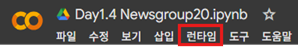

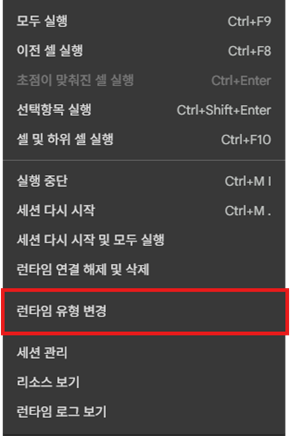

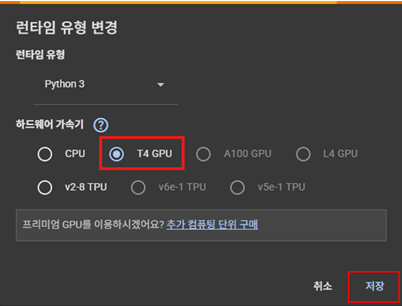

- 필요한 라이브러리 설치 및 호출

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils

import matplotlib.pyplot as plt
import numpy as np

- GPU 설정

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


- 시드 고정

    - 동일한 실습 환경에서도 모델의 학습 결과가 일관되도록 랜덤성을 최소화
    - 이를 통해 코드 실행 시 매번 동일한 결과를 재현

In [3]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## 1. Fashion MNIST 데이터셋 준비

#### 1.1 Fashion MNIST 데이터셋 불러오기
- `datasets.FashionMNIST` 클래스로 FashionMNIST 데이터셋 불러오기


In [4]:
# 이미지 데이터를 tensor로 바꿔주는 변환 함수
transform = transforms.ToTensor()

# FashionMNIST Train/Test 데이터가 저장된 Dataset 클래스를 반환
train_dataset = datasets.FashionMNIST(
    root      = './data/',
    train     = True,
    download  = True,
    transform = transform
)
test_dataset = datasets.FashionMNIST(
    root      = './data/',
    train     = False,
    download  = True,
    transform = transform
)

# DataLoader를 구축
train_loader = DataLoader(
    dataset     = train_dataset,
    batch_size  = 64
)
test_loader = DataLoader(
    dataset     = test_dataset,
    batch_size  = 64
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 199kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.35MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 23.8MB/s]


#### 1.2 불러온 Fashion MNIST 데이터셋 확인

In [5]:
# 불러온 FashionMNIST 데이터셋 확인
print(f'FashionMNIST Train 데이터 셋 정보 : {train_dataset}\n')
print(f'이미지 데이터의 크기 : {train_dataset.data.shape}\n')
print(f'각 이미지 데이터의 Label : {train_dataset.targets}\n\n')

FashionMNIST Train 데이터 셋 정보 : Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: ToTensor()

이미지 데이터의 크기 : torch.Size([60000, 28, 28])

각 이미지 데이터의 Label : tensor([9, 0, 0,  ..., 3, 0, 5])




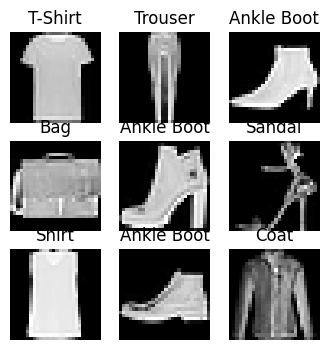

In [6]:
# Fashion MNIST 데이터 중 랜덤한 9개의 이미지를 시각화
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(4, 4))

cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## 2. 모델 구축, 학습, 평가
#### 2.1 모델 구축
![image.png](https://blog.kakaocdn.net/dn/b5XcJp/btqWUpKHPTL/wy9Z1Kg41sn6Nbqe2IKBMk/img.png)
  - Neural Network 모델을 정의
  - 총 3개의 fully connected layer(nn.Linear)로 구성된 모델
  - 마지막 fully connected layer는 Activation 함수를 포함하지 않음
  - 나머지 fully connected layer는 ReLU Activation  함수를 포함
  - 처음 이미지가 input으로 들어오기 위해서 flatten 과정이 필요

  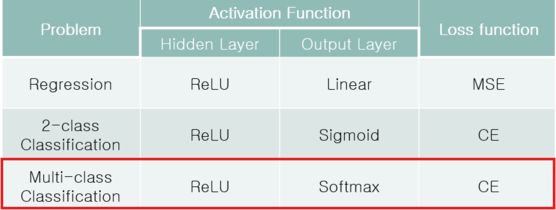
  


In [7]:
# 모델 정의
class MultiClassClassifier(nn.Module):
    def __init__(self):
        super(MultiClassClassifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        output = self.layers(x)
        return output

# 모델 구축
model = MultiClassClassifier().to(device)

#### 2.2 모델 학습 준비
  - **Loss Function** : 모델의 output이 실제 Label과 얼마나 유사한지를 나타내는 함수
    - 두 값이 서로 유사할수록 함수값이 작아지며, 이 함수를 최소화 하는 것이 모델의 최종 학습 목표
    - `nn.MSE()` : MSE Loss Function
    - `nn.BCELoss()` : (Binary Clssification을 위한) Cross Entropy Loss Function
    - `nn.CrossEntropyLoss()` : **Softmax** + Cross Entropy Loss Function
      - Softmax를 포함하고 있기 때문에, 마지막 layer의 activation 함수에 Softmax를 따로 넣어줄 필요가 없음
      - 또한 label(0~9)을 받으면 **자동으로 one-hot encoding으로 변환**해서 loss를 계산하기 때문에 편리함
  
  - **Optimizer** : Loss function이 최소화되도록 모델의 Weight를 업데이트 하는 역할 (Gradient Descent)
    - `nn.SGD(model.parameters(), learning rate)` : Gradient Descent를 수행하는 Optimizer
    - `model.parameters()` : Neural Network 모델의 Weight들

In [8]:
loss_function = nn.CrossEntropyLoss() # Loss Function
optimizer = optim.SGD(model.parameters(), lr=0.01)

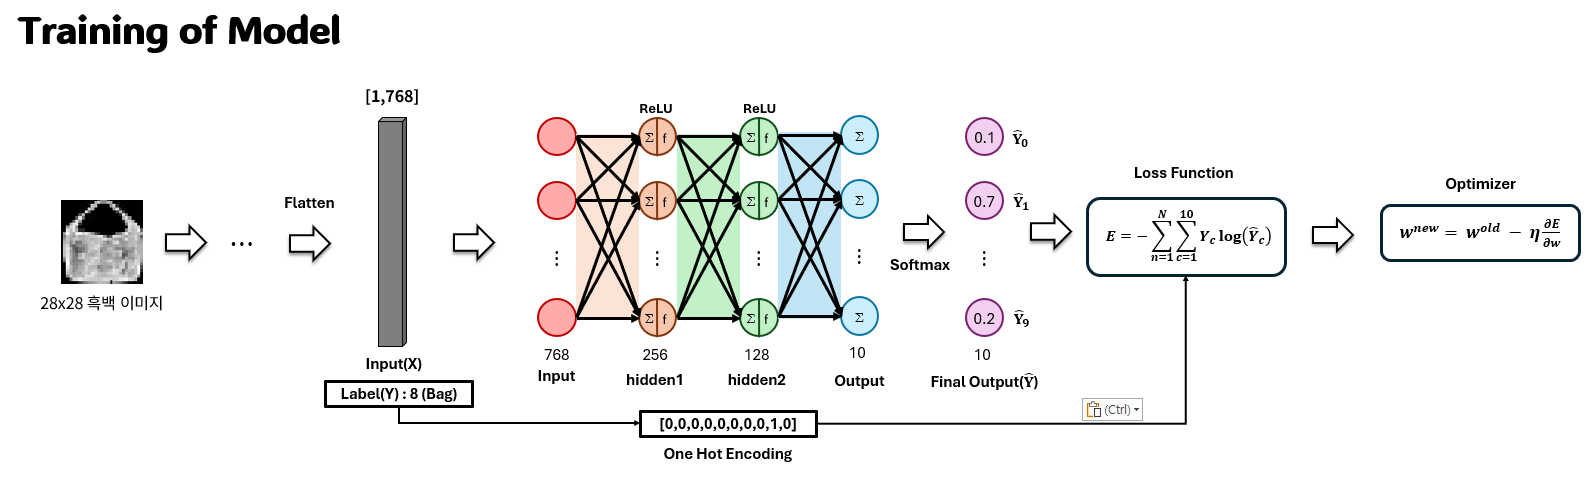

0. `model.train()` 으로 모델을 학습 상태로 전환
1. DataLoader에서 Train 데이터를 불러오기 (input,labels)
2. 모델에 input을 넣고 output을 출력하기
3. 모델의 output과 정답 labels으로 loss 계산하기
4. loss의 미분값을 계산하고 optimizer로 Gradient Descent 수행하기
  - `loss.backward()` : 계산한 loss의 미분값을 계산
  - `optimizer.step()` : 계산한 loss의 미분값으로 Gradient Descent를 진행
  - `opimizer.zero_grad()` : 계산한 미분값들을 비워주는 역할, 이 함수가 없으면 미분값들이 계속 누적되어 계산되기에 필수적으로 호출 필요

In [9]:
# 모델 학습을 위한 함수
def train(model, train_loader, optimizer, loss_function):
    model.train()
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        output = model(inputs)

        optimizer.zero_grad()
        loss = loss_function(output, labels)
        loss.backward()
        optimizer.step()

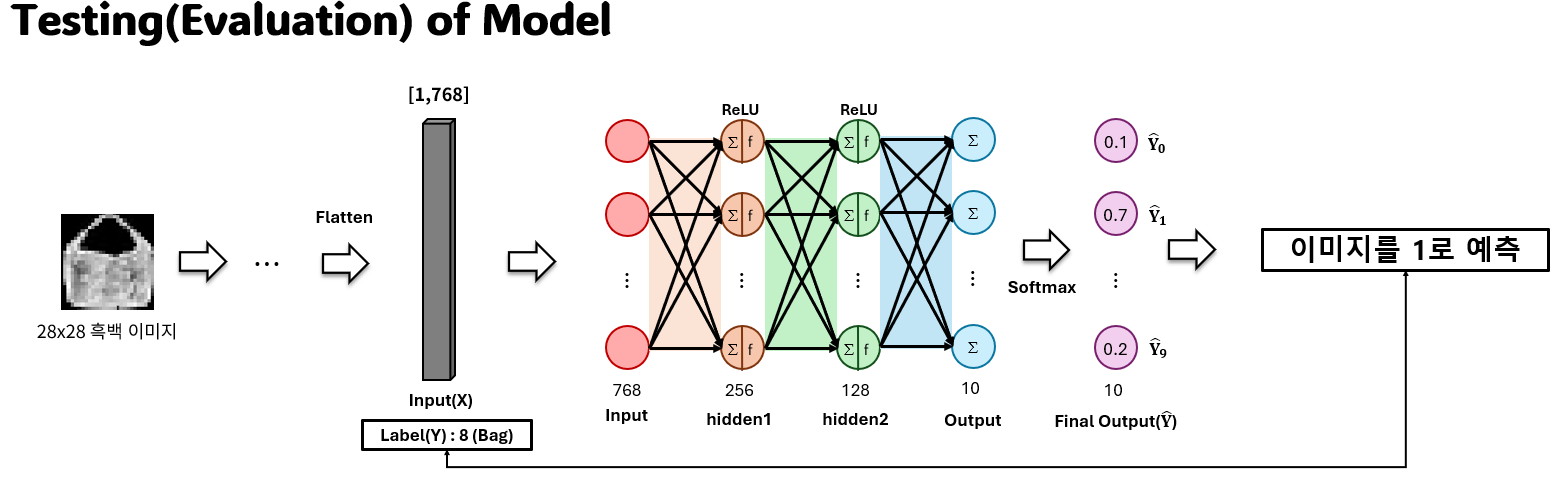

1. `model.eval()`로 모델을 평가 상태로 전환
2. DataLoader로 Test 데이터 불러오기 (input, labels)
3. 모델에 input을 넣고 output을 출력하기
4. **모델의 output 중 가장 값이 큰 index가 모델이 예측한 값**
5. 모델의 예측과 정답 label이 얼마나 유사한지를 비교하여 성능을 평가
  - 성능 평가 지표
    - Test Loss : Test 데이터셋에 대한 모델의 평균 Loss 값
    - Test Accuracy : 모델이 Test 데이터셋에 있는 전체 데이터 중에서 라벨을 올바르게 맞춘 비율
      - (모델이 라벨을 맞춘 데이터 수 / 전체 데이터 수)

In [10]:
# 모델의 성능을 평가하기 위한 함수
def evaluate(model, test_loader, loss_function):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)

            test_loss += loss_function(output, labels).item()

            pred = output.argmax(dim=1) # 모델이 예측한 output 중 가장 값이 큰 index가 예측값

            correct += pred.eq(labels).sum().item()

    # Test Loss와 Test Accuracy 계산
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [11]:
# 모델을 학습할 횟수
num_epochs = 10

# 시드 고정
set_seed(14)

# 모델 학습 및 평가
for epoch in range(1, num_epochs + 1):
    train(model, train_loader, optimizer, loss_function)
    test_loss, test_accuracy = evaluate(model, test_loader, loss_function)

    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

[1] Test Loss: 0.0131, Accuracy: 68.25%
[2] Test Loss: 0.0105, Accuracy: 76.47%
[3] Test Loss: 0.0093, Accuracy: 79.22%
[4] Test Loss: 0.0087, Accuracy: 80.27%
[5] Test Loss: 0.0083, Accuracy: 81.02%
[6] Test Loss: 0.0080, Accuracy: 81.48%
[7] Test Loss: 0.0078, Accuracy: 82.01%
[8] Test Loss: 0.0077, Accuracy: 82.27%
[9] Test Loss: 0.0075, Accuracy: 82.75%
[10] Test Loss: 0.0074, Accuracy: 83.12%


- 모델 예측 결과 시각화

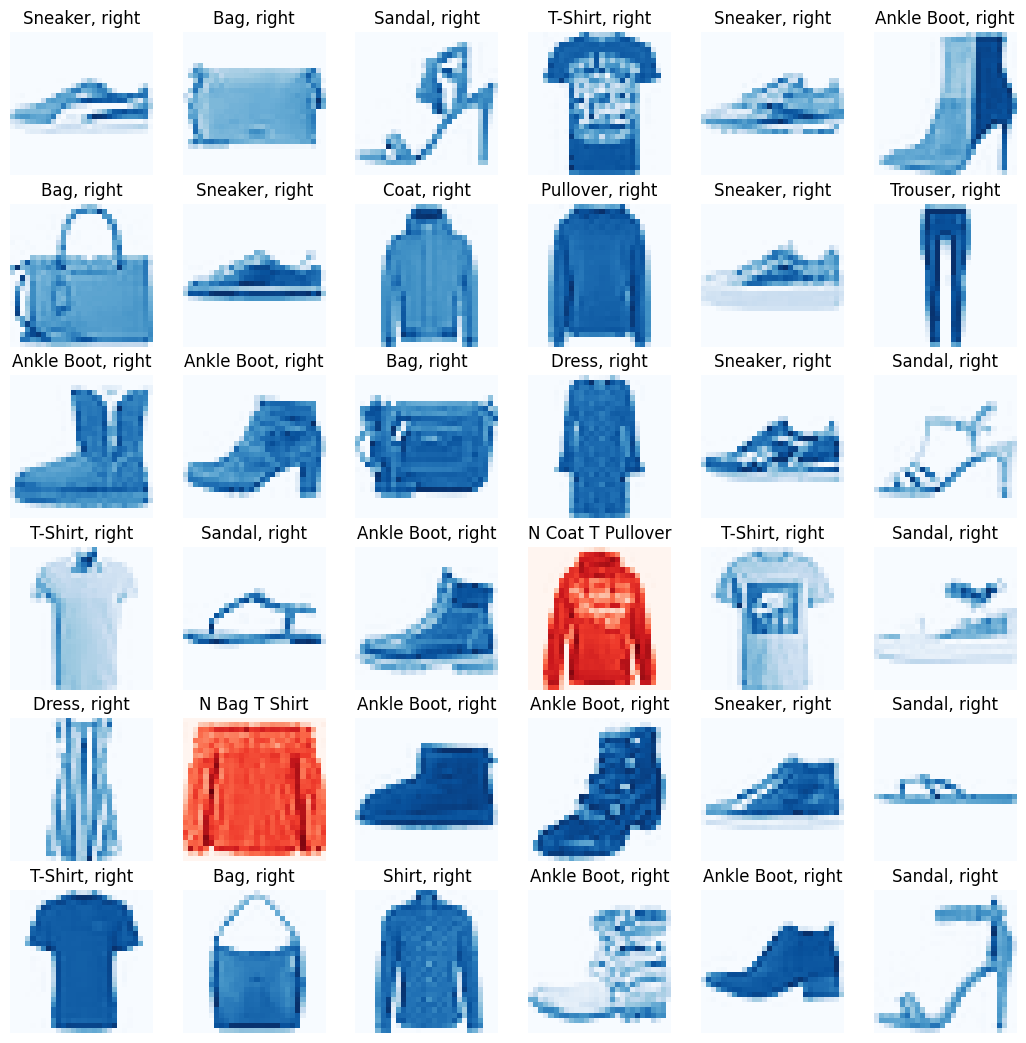

In [13]:
# 6x6 개의 데이터를 시각화
columns = 6
rows = 6
fig = plt.figure(figsize=(13,13))

model.eval()
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(test_dataset))

    # 확인하고 싶은 데이터셋 구성
    input_img = test_dataset[data_idx][0].unsqueeze(dim=0).to(device)

    # 모델로 데이터의 label을 예측
    output = model(input_img)
    _, argmax = torch.max(output, 1)
    pred = labels_map[argmax.item()]
    label = labels_map[test_dataset[data_idx][1]]

    fig.add_subplot(rows, columns, i)

    if pred == label: # 모델이 정답 label을 맞추었다면 파란색으로 표시
        plt.title(pred + ', right')
        cmap = 'Blues'
    else: # 모델이 정답 label을 맞추지 못햇다면 빨간색으로 표시
        plt.title('N ' + pred + ' T ' +  label)
        cmap = 'Reds'
    plot_img = test_dataset[data_idx][0][0,:,:]
    plt.imshow(plot_img, cmap=cmap)
    plt.axis('off')

plt.show()

## 3. 새로운 모델 설계, 학습, 평가



- **Linear Layer 개수** / **Linear Layer의 Input/Output 크기** / **학습 횟수**를 자유롭게 변형해보면서 성능 변화를 확인

In [14]:
num_linear_layers = 3 # Hidden Layer 개수
inout_dims = [[784,256],[256,128],[128,10]] # Hidden Layer의 노드 개수를 결정할 Input과 Output 크기(차원)
num_epochs = 10 # 모델을 학습할 횟수

In [15]:
class CustomNet(nn.Module):
    def __init__(self, num_hidden_layers, inout_dims):
        super(CustomNet, self).__init__()
        layers = [nn.Flatten()]  # 먼저 flatten 추가

        for i in range(num_linear_layers):
            in_dim, out_dim = inout_dims[i] # ex : inout_dims[0] = [784,256], in_dim=784 , out_dim = 256
            layers.append(nn.Linear(in_dim, out_dim)) # ex : nn.Linear(784,256)
            if i != num_hidden_layers - 1: # 마지막 hidden layer를 제외하고 ReLU를 추가
                layers.append(nn.ReLU())

        self.layers = nn.Sequential(*layers) # nn.Sequential로 정의한 layer들 묶어주기

    def forward(self, x):
        return self.layers(x)

# 모델 구축
custom_model = CustomNet(num_linear_layers, inout_dims).to(device)

In [16]:
loss_function = nn.CrossEntropyLoss() # Loss Function
optimizer = optim.SGD(custom_model.parameters(), lr=0.01) # Optimizer


# 모델 학습을 위한 함수
def train(model, train_loader, optimizer, loss_function):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = loss_function(output, labels)
        loss.backward()
        optimizer.step()

# 모델의 성능을 평가하기 위한 함수
def evaluate(model, test_loader ,loss_function):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            test_loss += loss_function(output, labels)
            pred = output.max(dim=1)[1]
            correct += pred.eq(labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

# 시드 고정
set_seed(14)

# 모델 학습 및 평가
for epoch in range(1, num_epochs + 1):
    train(custom_model, train_loader, optimizer, loss_function)
    test_loss, test_accuracy = evaluate(custom_model, test_loader, loss_function)

    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

[1] Test Loss: 0.0131, Accuracy: 68.02%
[2] Test Loss: 0.0105, Accuracy: 76.17%
[3] Test Loss: 0.0093, Accuracy: 79.02%
[4] Test Loss: 0.0087, Accuracy: 80.21%
[5] Test Loss: 0.0084, Accuracy: 80.97%
[6] Test Loss: 0.0081, Accuracy: 81.27%
[7] Test Loss: 0.0079, Accuracy: 81.86%
[8] Test Loss: 0.0077, Accuracy: 82.10%
[9] Test Loss: 0.0076, Accuracy: 82.59%
[10] Test Loss: 0.0075, Accuracy: 82.82%


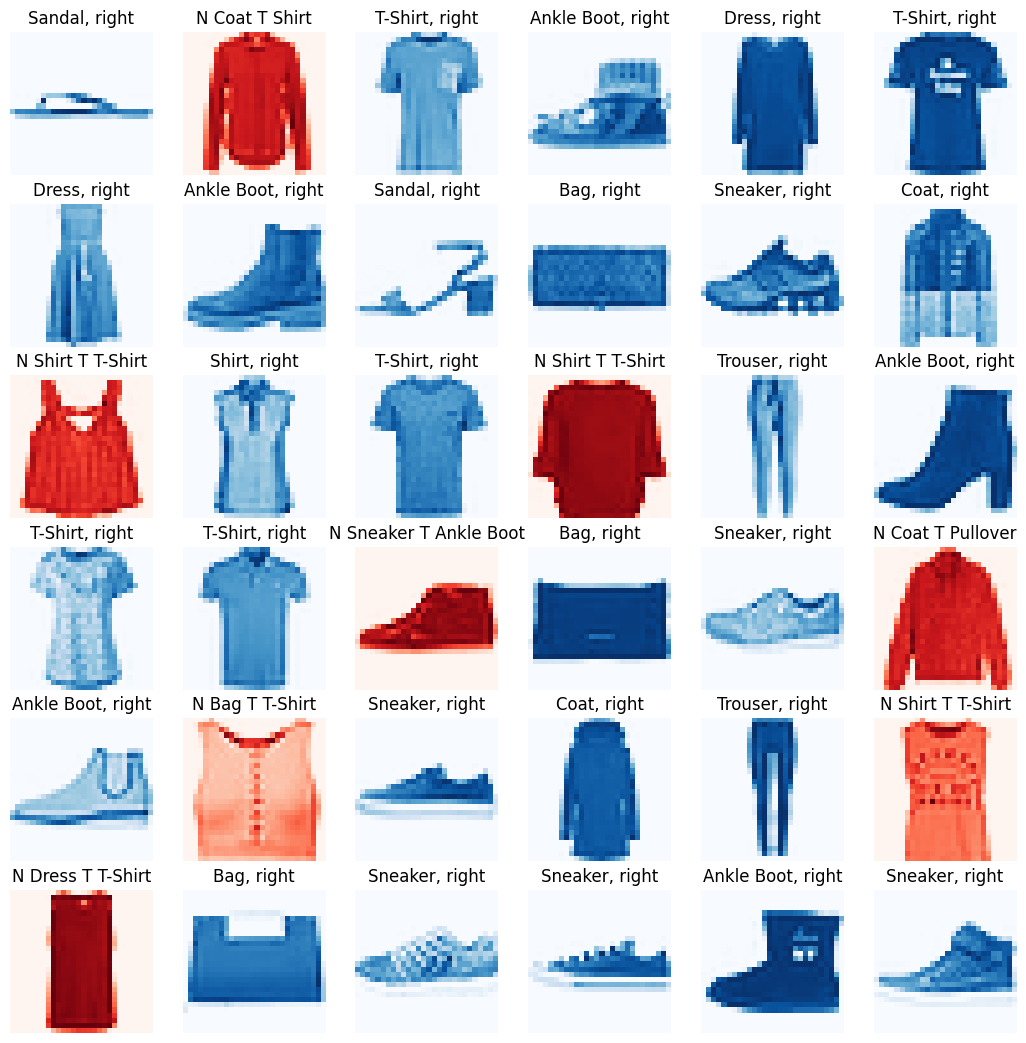

In [17]:
# 모델 결과 시각화
columns = 6
rows = 6
fig = plt.figure(figsize=(13,13))

custom_model.eval()
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(test_dataset))
    input_img = test_dataset[data_idx][0].unsqueeze(dim=0).to(device)

    output = custom_model(input_img)
    _, argmax = torch.max(output, 1)
    pred = labels_map[argmax.item()]
    label = labels_map[test_dataset[data_idx][1]]

    fig.add_subplot(rows, columns, i)
    if pred == label:
        plt.title(pred + ', right')
        cmap = 'Blues'
    else:
        plt.title('N ' + pred + ' T ' +  label)
        cmap = 'Reds'
    plot_img = test_dataset[data_idx][0][0,:,:]
    plt.imshow(plot_img, cmap=cmap)
    plt.axis('off')

plt.show()